In [86]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely as shp  

In [87]:
# read in point data )
df = pd.read_csv("../data/csv/ar_samples_merged_xy.csv")

In [88]:
# read in geo jsons

gdf_geol = gpd.read_file("../data/gis/polygon/geology.geojson")
gdf_faults = gpd.read_file("../data/gis/polygon/geofaults.geojson")
gdf_landuse = gpd.read_file("../data/gis/polygon/landuse.geojson")
gdf_cropland = gpd.read_file("../data/gis/polygon/cropland.geojson")
gdf_cnty = gpd.read_file("../data/gis/polygon/county.geojson")
gdf_mines = gpd.read_file("../data/gis/point/mines.geojson")
pred = gpd.read_file("../data/gis/polygon/predicted-arsenic.geojson")
pws = gpd.read_file("../data/gis/polygon/pws.geojson")

In [49]:
# function to print the name and crs for each geodataframe above

def print_crs():
    print('geology crs:', gdf_geol.crs)
    print('faults crs:', gdf_faults.crs)
    print('landuse crs:', gdf_landuse.crs)
    print('cropland crs:', gdf_cropland.crs)
    print('county crs:', gdf_cnty.crs)
    print('mines crs:', gdf_mines.crs)
    print('sample data crs:', ar.crs)

#  plot a polygon and point set

def basic_map(gdf1, gdf2):
    fig, ax = plt.subplots(figsize=(10,10))
    gdf1.plot(ax=ax, color='none', edgecolor='black')
    gdf2.plot(ax=ax, color='red')
    plt.show()

print_crs()

geology crs: EPSG:4269
faults crs: EPSG:32119
landuse crs: EPSG:4269
cropland crs: EPSG:4269
county crs: EPSG:4326
mines crs: EPSG:4326
sample data crs: EPSG:4269


The code below is what differs this notebook from the main gis processing notebook. if you had to geocode a portion of the samples then you'll have to project them seperately and then merge them back together. This is what the code below does. Comment out next two code blocks if no geocoding was done.

In [50]:
# Create two point datasets, one for points that got their XY coordinates from the merge with permit data, 
# and one for points that got their XY from google geocoding. This is because they likely have different coordinate systems.
# Once they have the same coordinate system, the geoocoded points can be merged with the permit points.

ar = df[df['X'].notnull()]
geocoded = df[df['X'].isnull()]

# convert both to geodataframes

ar = gpd.GeoDataFrame(ar, geometry=gpd.points_from_xy(ar.X, ar.Y), crs = "EPSG:4269")

# specify the coordinate system for google maps output (WGS84)
geocoded = gpd.GeoDataFrame(geocoded, geometry=gpd.points_from_xy(geocoded.geoX, geocoded.geoY), crs="EPSG:4326")

# change to NAD83
geocoded = geocoded.to_crs("EPSG:4269")


# concatenate the two geo dataframes
ar = pd.concat([ar, geocoded], ignore_index=True)


# check the length of the merged dataset
len(ar)

1687

<Axes: >

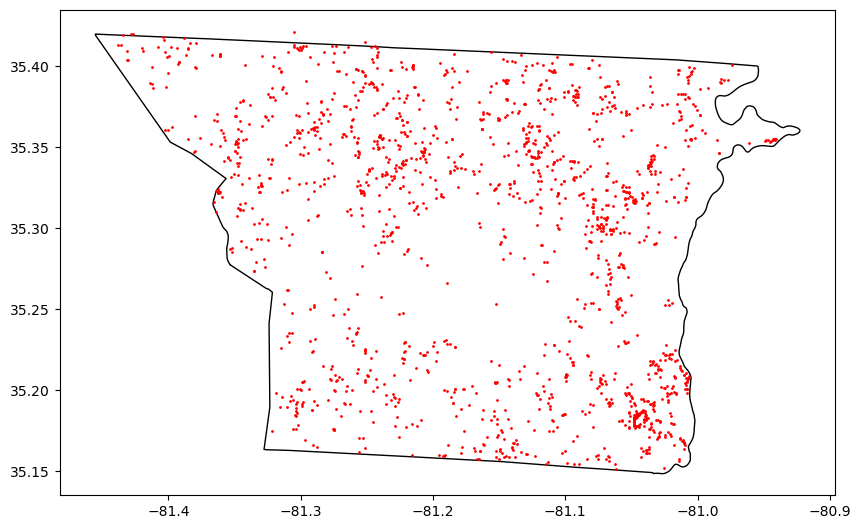

In [51]:

# Filter out gaston county from NC counties

gdf_cnty = gdf_cnty[gdf_cnty['County'] == 'Gaston']

gdf_cnty.to_crs("EPSG:4269", inplace=True)

# check all points within county
# by plotting county border and ar points
# using subplots

fig, ax = plt.subplots(figsize=(10,10))
gdf_cnty.plot(ax=ax, color='white', edgecolor='black')
ar.plot(ax=ax, color='red', markersize=1)

In [52]:
# clip points to county (5 dropped)

gdf_ar = gpd.clip(ar, gdf_cnty)

# check the length of the clipped dataset

len(ar)

1687

# Clip Polygon Data To Gaston County

<Axes: >

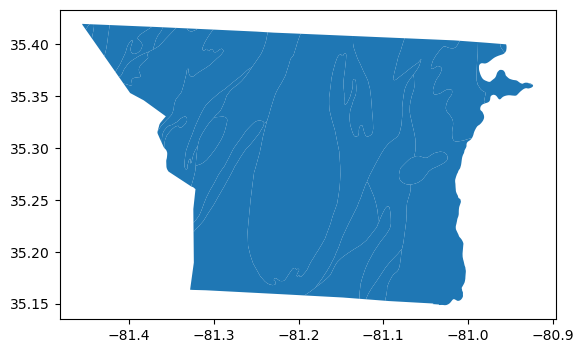

In [53]:
# clip the geology data to the county boundary

gdf_geol = gpd.clip(gdf_geol, gdf_cnty)
gdf_geol.plot()

Read in Gaston County Water Map prediction surface, clip by Public Water System Boundaries

In [54]:
# filter out systems where 'wapcs' = "Gaston"

pws = pws[pws['wapcs'] == 'Gaston']

EPSG:2264
EPSG:4326
EPSG:4269
EPSG:4269


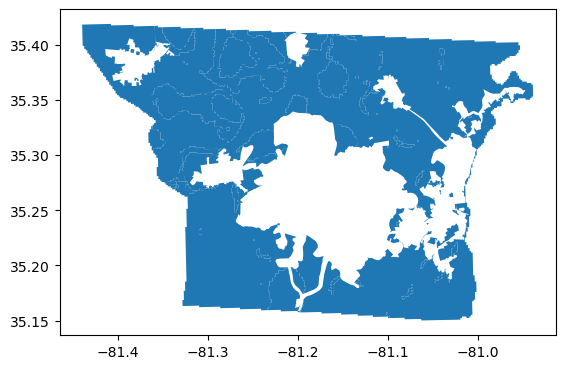

In [55]:
print(pred.crs)
print(pws.crs)

# set crs to 4269 for all dataframes
pred = pred.to_crs("EPSG:4269")
pws = pws.to_crs("EPSG:4269")

print(pred.crs)
print(pws.crs)

# recode the severity column to a more readable format

pred['pred'] = pred['severity'].replace(['good','warn','danger'],['< 0.005','0.005 - 0.01','> 0.01'])

#clip the pred dataframe to the pws dataframe

pred_clipped = pred.overlay(pws, how='symmetric_difference')

# check results

#pred.plot()
pred_clipped.plot()


# save the clipped data to a geojson file

pred_clipped.to_file("../data/gis/polygon/predicted-arsenic-clipped.geojson", driver='GeoJSON')

## Merge bedrock type to wells

In [56]:
# build index of column names for retaining after spatial join

columns = ['id',
            'full_add',
            'date_tested',
            'year_tested',
            'ar',
            'group',
            'group_five',
            'group_mcl',
            'ph',
            'sample_id',
            'geometry']

geol_columns = ['geocode', 'belt2','type']

columns.extend(geol_columns)

columns

['id',
 'full_add',
 'date_tested',
 'year_tested',
 'ar',
 'group',
 'group_five',
 'group_mcl',
 'ph',
 'sample_id',
 'geometry',
 'geocode',
 'belt2',
 'type']

In [57]:
# Join the bedrock type, "geocode", from the gdf_geol to each well sample point, from gdf_ar, 
# based on the polygon from gdf_geol they lie within

gdf_ar = gpd.sjoin(gdf_ar, gdf_geol, how='left', predicate='within')

In [58]:
# drop unneeded columns

gdf_ar = gdf_ar[columns]

In [59]:
# check the result

#gdf_ar.head()

---

## Read in Mining data, Land Use Data, Faults

Calculate Distances to Wells, Count in Neighborhood

Calculate Land Use type for well location

Calculate distance to cropland

Sourced from USGS Mineral Resources Data System

In [60]:
# Join the landuse type, from the gdf_landuse to each well sample point
# based on the polygon from gdf_landuse they lie within

gdf_ar = gpd.sjoin(gdf_ar, gdf_landuse, how='left', predicate='within')

# verify the join

gdf_ar.head()

,id,full_add,date_tested,year_tested,ar,group,group_five,group_mcl,ph,sample_id,geometry,geocode,belt2,type,index_right,VALUE
1284,NaN,"3260 LAKE POINT DR, BELMONT, NC 28012",2019-04-02,2019,0.0,0,0,0,7.4,1148,POINT (-81.02565 35.15149),PzZq,Charlotte Belt,Intrusive Rocks,12,22.0
427,11011,"217 COMMODORE CT, BELMONT, NC 28012",2016-09-12,2016,0.0,0,0,0,7.3,800,POINT (-81.03676 35.16103),PzZq,Charlotte Belt,Intrusive Rocks,6,21.0
1390,LS_09152019_007,"421 SEBRING DR, BELMONT, NC 28012",2019-09-15,2019,0.0,0,0,0,8.1,1337,POINT (-81.03839 35.16121),PzZq,Charlotte Belt,Intrusive Rocks,12,22.0
131,4178,"517 SEBRING DR, BELMONT, NC 28012",2012-06-14,2012,0.0,0,0,0,7.4,181,POINT (-81.03894 35.16280),PzZq,Charlotte Belt,Intrusive Rocks,12,22.0
440,10029,"414 ARMSTRONG RD, BELMONT, NC 28012",2016-10-13,2016,0.0,0,0,0,7.2,820,POINT (-81.03812 35.16285),PzZq,Charlotte Belt,Intrusive Rocks,7,43.0


In [61]:
# apply labels for landuse types

li = []
for each in gdf_ar['VALUE']:
    if each in [21,22,23,24]:
        li.append('Developed')
    elif each in [31]:
        li.append('Barren')
    elif each in [41,42,43]:
        li.append('Forest')
    elif each in [51,52]:
        li.append('Shrubland')
    elif each in [71,72,73,74]:
        li.append('Herbaceous')
    elif each in [81]:
        li.append('Pasture')
    elif each in [82]:
        li.append('Crops')
    elif each in [90,95]:
        li.append('Wetlands')
    else:
        li.append('Other')

gdf_ar['landuse'] = li

# drop unneeded columns

gdf_ar = gdf_ar.drop(columns=['index_right', 'VALUE'])

# check the result

gdf_ar['landuse'].value_counts()

landuse
Developed     1044
Forest         338
Pasture        235
Herbaceous      37
Shrubland       17
Crops            8
Other            2
Barren           1
Wetlands         1
Name: count, dtype: int64

In [62]:
# re-assign landuse value to be other if not developed,forest, or pasture

li = []
for each in gdf_ar['landuse']:
    if each in ['Developed','Forest','Pasture']:
        li.append(each)
    else:
        li.append('Other')

gdf_ar['landuse'] = li

# check the result

gdf_ar['landuse'].value_counts()

landuse
Developed    1044
Forest        338
Pasture       235
Other          66
Name: count, dtype: int64

**Calculate Mining Denisty Variables in Neighborhood**

In [63]:
# change crs for the mines data and arsenic data to a projected CRS for distance calculations

gdf_mines = gdf_mines.to_crs("EPSG:32617")

gdf_ar = gdf_ar.to_crs("EPSG:32617")



# calculate the number of mines in a 250m radius around each well sample point
gdf_ar['num_mines_250'] = gdf_ar.buffer(250).apply(lambda x: gdf_mines.intersects(x).sum())

# calculate the number of mines in a 500m radius around each well sample point
gdf_ar['num_mines_500'] = gdf_ar.buffer(500).apply(lambda x: gdf_mines.intersects(x).sum())

# calculate the number of mines in a 1 km radius around each well sample point
gdf_ar['num_mines_1k'] = gdf_ar.buffer(1000).apply(lambda x: gdf_mines.intersects(x).sum())

# calculate the number of mines in a 2 km radius around each well sample point
gdf_ar['num_mines_2k'] = gdf_ar.buffer(2000).apply(lambda x: gdf_mines.intersects(x).sum())

# calculate the distance to the nearest mine for each well sample point
gdf_ar['dist_to_mine'] = gdf_ar.apply(lambda x: int(gdf_mines.distance(x.geometry).min()), axis=1)

# check the results
gdf_ar.head()

,id,full_add,date_tested,year_tested,ar,group,group_five,group_mcl,ph,sample_id,geometry,geocode,belt2,type,landuse,num_mines_250,num_mines_500,num_mines_1k,num_mines_2k,dist_to_mine
1284,NaN,"3260 LAKE POINT DR, BELMONT, NC 28012",2019-04-02,2019,0.0,0,0,0,7.4,1148,POINT (497663.817 3889842.886),PzZq,Charlotte Belt,Intrusive Rocks,Developed,0,0,0,0,3862
427,11011,"217 COMMODORE CT, BELMONT, NC 28012",2016-09-12,2016,0.0,0,0,0,7.3,800,POINT (496652.530 3890900.989),PzZq,Charlotte Belt,Intrusive Rocks,Developed,0,0,0,0,4288
1390,LS_09152019_007,"421 SEBRING DR, BELMONT, NC 28012",2019-09-15,2019,0.0,0,0,0,8.1,1337,POINT (496504.098 3890921.453),PzZq,Charlotte Belt,Intrusive Rocks,Developed,0,0,0,0,4138
131,4178,"517 SEBRING DR, BELMONT, NC 28012",2012-06-14,2012,0.0,0,0,0,7.4,181,POINT (496454.067 3891097.317),PzZq,Charlotte Belt,Intrusive Rocks,Developed,0,0,0,0,4068
440,10029,"414 ARMSTRONG RD, BELMONT, NC 28012",2016-10-13,2016,0.0,0,0,0,7.2,820,POINT (496528.825 3891102.368),PzZq,Charlotte Belt,Intrusive Rocks,Forest,0,0,0,0,4127


Calculate distance to farms

In [64]:

# read in cropland polygon data from geojson
gdf_crops = gpd.read_file("../data/gis/polygon/cropland.geojson")

# set crs
gdf_crops.crs = 4269

# read in the geologic fault data from geojson
gdf_faults = gpd.read_file("../data/gis/polygon/geofaults.geojson")

# set crs
gdf_faults.crs = 32119


In [65]:
# change crs for the crop data and fault data to a projected CRS for distance calculations

gdf_crops = gdf_crops.to_crs("EPSG:32617")

gdf_faults = gdf_faults.to_crs("EPSG:32617")

# calculate distance to NEAREST cropland polygon for each well sample point

gdf_ar['dist_crops'] = gdf_ar.apply(lambda x: int(gdf_crops.distance(x.geometry).min()), axis=1)

# calculate distance to faultline or each well sample point


gdf_ar['dist_fault'] = gdf_ar.geometry.apply(lambda x: int(gdf_faults.distance(x).min()))

In [66]:
gdf_ar['dist_crops'].describe()

count     1683.000000
mean      2483.410576
std       2237.748741
min          0.000000
25%        631.000000
50%       1757.000000
75%       3987.500000
max      11594.000000
Name: dist_crops, dtype: float64

In [67]:
gdf_ar['dist_fault'].describe()

count     1683.000000
mean     13795.909091
std       8784.712167
min         22.000000
25%       5693.500000
50%      12833.000000
75%      20877.500000
max      30880.000000
Name: dist_fault, dtype: float64

In [68]:
# Change the crs of ar, mines, and crops back to 4269 for plotting

gdf_ar = gdf_ar.to_crs("EPSG:4269")

gdf_mines = gdf_mines.to_crs("EPSG:4269")

gdf_crops = gdf_crops.to_crs("EPSG:4269")


In [70]:
gdf_mines.isna().sum()

dep_id           0
url              0
mrds_id       2176
mas_id        1923
site_name        0
latitude         0
longitude        0
region        5200
country          0
state            0
county           3
com_type         6
commod1        338
commod2       5052
commod3       3964
oper_type        0
dep_type      4332
prod_size     3279
dev_stat         0
ore           4155
gangue        4639
other_matl    5059
orebody_fm    4282
work_type     4750
model         4915
alteration    4812
conc_proc     5061
names         4699
ore_ctrl      4648
reporter        42
hrock_unit    4854
hrock_type    4096
arock_unit    5016
arock_type    4861
structure     4470
tectonic      4806
ref             21
yfp_ba        5129
yr_fst_prd    4726
ylp_ba        5193
yr_lst_prd    5122
dy_ba         5119
disc_yr       4596
prod_yrs      4964
discr         5028
score            0
geometry         0
dtype: int64

In [77]:
# filter mines to bounds of county + 1 degree buffer to account for any mines that may be outside the county boundary

gdf_mines = gdf_mines[gdf_mines.within(gdf_cnty.geometry.unary_union.buffer(1))]

In [78]:
# checks to see if commod1 is missing, and if so fill the value with the value in commod2 or commod3 if present

gdf_mines['commod1'].fillna(gdf_mines['commod3'], inplace=True)
gdf_mines.isna().sum()

dep_id           0
url              0
mrds_id        869
mas_id        1060
site_name        0
latitude         0
longitude        0
region        2401
country          0
state            0
county           0
com_type         3
commod1          0
commod2       2307
commod3       1604
oper_type        0
dep_type      1968
prod_size     1341
dev_stat         0
ore           1745
gangue        2071
other_matl    2332
orebody_fm    1764
work_type     2135
model         2239
alteration    2195
conc_proc     2332
names         2161
ore_ctrl      2109
reporter        16
hrock_unit    2218
hrock_type    1671
arock_unit    2368
arock_type    2261
structure     1942
tectonic      2223
ref             12
yfp_ba        2345
yr_fst_prd    2047
ylp_ba        2398
yr_lst_prd    2363
dy_ba         2349
disc_yr       1970
prod_yrs      2225
discr         2278
score            0
geometry         0
dtype: int64

In [79]:
# remove mine if dev_stat = "Prospect"

gdf_mines = gdf_mines[gdf_mines['dev_stat'] != 'Prospect']
gdf_mines[['dep_id', 'geometry','oper_type','prod_size', 'score', 'com_type', 'commod1']]

,dep_id,geometry,oper_type,prod_size,score,com_type,commod1
2,10009176,POINT (-82.26652 35.98342),Unknown,Y,D,B,"Niobium (Columbium), Tantalum, Mica, Feldspar"
3,10009177,POINT (-82.04984 35.93342),Unknown,Y,D,B,"Niobium (Columbium), Tantalum, Mica, Feldspar"
13,10025083,POINT (-82.27429 35.88870),Unknown,Y,C,B,"Mica, Feldspar"
28,10025152,POINT (-82.09762 36.02815),Unknown,Y,C,N,"Mica, Feldspar"
29,10025147,POINT (-82.13206 36.03898),Unknown,Y,C,N,Mica
...,...,...,...,...,...,...,...
5172,60001761,POINT (-81.94044 35.88569),Unknown,S,D,B,Dolomite
5178,60001767,POINT (-80.07038 35.70929),Unknown,M,D,NaN,Gold
5186,60001775,POINT (-80.21009 35.74899),Unknown,S,D,M,Gold
5189,60001778,POINT (-80.10478 35.53180),Unknown,S,D,N,"Stone, Dimension"


In [80]:
gdf_mines['oper_type'].value_counts()

oper_type
Unknown                1241
Surface                 866
Underground             131
Surface-Underground     107
Processing Plant         43
Offshore                 11
Placer                    2
Name: count, dtype: int64

In [81]:

gdf_mines['prod_size'].value_counts()


prod_size
S    575
Y    217
N    189
M     58
U     15
L      6
Name: count, dtype: int64

In [82]:

gdf_mines['score'].value_counts()


score
D    1717
C     444
B     227
E      12
A       1
Name: count, dtype: int64

In [83]:

gdf_mines['com_type'].value_counts()


com_type
N    1655
M     617
B     126
Name: count, dtype: int64

In [84]:

gdf_mines['commod1'].value_counts()


commod1
Mica                                         653
Sand and Gravel, Construction                293
Feldspar                                     272
Gold                                         261
Stone, Crushed/Broken                        104
                                            ... 
Zirconium, Thorium, Gold, Titanium, Metal      1
Nickel, Tungsten, Asbestos, Chromium           1
Lead, Silver, Tungsten, Beryllium, Copper      1
Olivine, Chromium, Asbestos                    1
Dolomite                                       1
Name: count, Length: 114, dtype: int64

In [85]:

# save mines gdf as geojson

gdf_mines.to_file('../data/gis/point/mines-w-info.geojson', driver='GeoJSON')



arsenic is commonly concentrated in sulfide-bearing mineral deposits, 
especially those associated with gold mineralization, and it has a strong affinity 
for pyrite, one of the more ubiquitous minerals in the Earth’s crust. 
It is also concentrated in hydrous iron oxides.